<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Interpreting the sentence classification of legal texts using LIME

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

This notebook demonstrates how to use the LIME explainable-AI method in [DIANNA](https://github.com/dianna-ai/dianna) to explain a text classification model created as part of the [Nature of EU Rules project](https://research-software-directory.org/projects/the-nature-of-eu-rules-strict-and-detailed-or-lacking-bite). The model is used to perform binary classification of individual sentences from EU legislation to determine whether they specify a regulation or not (i.e., whether they specify a legal obligation or prohibition that some legal entity should comply with). [Here's an example](https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32012R1215&qid=1724343987254) of what an EU legislative document looks like.

##### Regulatory sentence example:

```Citizens of all Member States shall separate their recyclables before disposing of trash, or else face a fine.```

##### Non-regulatory (constitutive) sentence example:

```This Regulation shall apply in civil and commercial matters whatever the nature of the court or tribunal.```

**Note:** while the occurrence of words like ``shall`` and ``must`` (which are called **deontic** words) are necessary condition for a sentence to be classified as regulatory, they are not a sufficient condition.

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

#### 0. Imports and paths

In [2]:
from torch.utils.data import DataLoader
from typing import Iterable
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
import xgboost

import dianna
from dianna import visualization
from dianna.utils.downloader import download
from dianna.utils.tokenizers import SpacyTokenizer

C:\Users\ChristiaanMeijer\anaconda3\envs\dianna3112\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
class_names = ['constitutive', 'regulatory']
model_path = download('inlegal_bert_xgboost_classifier.json', 'model')

# 1 - Define test data

In [4]:
constitutive_statement_0 = "The purchase, import or transport from Syria of crude oil and petroleum products shall be prohibited."
constitutive_statement_1 = "This Decision shall enter into force on the twentieth day following that of its publication in the Official Journal of the European Union."
regulatory_statement_0 = "Where observations are submitted, or where substantial new evidence is presented, the Council shall review its decision and inform the person or entity concerned accordingly."
regulatory_statement_1 = "The relevant Member State shall inform the other Member States of any authorisation granted under this Article."
regulatory_statement_2 = "Member States shall cooperate, in accordance with their national legislation, with inspections and disposals undertaken pursuant to paragraphs 1 and 2."

# 2 - Load and prepare the model

The model is a combination of a pretrained transformer used as a feature extractor, with an XGBoost model trained on top. The following cells load the model into the variable called `model_runner`.

In [5]:
from transformers import AutoTokenizer, AutoModel
def create_features(texts: list[str], model_tag="law-ai/InLegalBERT") -> torch.Tensor:
    """Create features for a list of texts."""
    max_length = 512
    tokenizer = AutoTokenizer.from_pretrained(model_tag)
    model = AutoModel.from_pretrained(model_tag)

    def process_batch(batch: Iterable[str]):
        cropped_texts = [text[:max_length] for text in batch]
        encoded_inputs = tokenizer(cropped_texts, padding='longest', truncation=True, max_length=max_length,
                                   return_tensors="pt")
        with torch.no_grad():
            outputs = model(**encoded_inputs)
        last_hidden_states = outputs.last_hidden_state
        sentence_features = last_hidden_states.mean(dim=1)
        return sentence_features

    dataloader = DataLoader(texts, batch_size=1)  # batch size of 1 was quickest for my development machine
    features = [process_batch(batch) for batch in tqdm(dataloader, desc=f'Creating features')]
    return np.array(torch.cat(features, dim=0))



In [6]:
models={}
def classify_texts(texts: list[str], model_path, return_proba: bool = False):
    """Classifies every text in a list of texts using the xgboost model stored in model_path.

    The xgboost model will be loaded and used to classify the texts. The texts however will first be processed by a
    large language model which will do the feature extraction for every text. The classifications of the
    xgboost model will be returned.
    For training the xgboost model, see train_legalbert_xgboost.py.

    Parameters
    ----------
    texts
        A list of strings of which each needs to be classified.
    model_path
        The path to a stored xgboost model
    return_proba
        return the probabilities of the model

    Returns
    -------
        List of classifications, one for every text in the list

    """
    features = create_features(texts)
    if model_path not in models:
        print(f'Loading model from {model_path}.')
        model = xgboost.XGBClassifier()
        model.load_model(model_path)
        models[model_path] = model

    model = models[model_path]
    if return_proba:
        return model.predict_proba(features)
    return model.predict(features)

In [7]:
class StatementClassifier:
    def __init__(self):
        self.tokenizer = SpacyTokenizer(name='en_core_web_sm')

    def __call__(self, sentences):
        # ensure the input has a batch axis
        if isinstance(sentences, str):
            sentences = [sentences]

        probs = classify_texts(sentences, model_path, return_proba=True)

        return np.transpose([(probs[:, 0]), (1 - probs[:, 0])])

model_runner = StatementClassifier()

## Test the model

In [8]:
statements = [constitutive_statement_0, constitutive_statement_1, regulatory_statement_0, regulatory_statement_1,
               regulatory_statement_2]
actual_classes = [class_names[c] for c in [0,0,1,1,1]]
model_outputs = model_runner(statements)
predictioned_classes = [class_names[m] for m in np.argmax(model_outputs, axis=1)]

pd.DataFrame({'statement': statements, 'prediction': predictioned_classes, 'actual': actual_classes})

Creating features: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

Loading model from C:\Users\ChristiaanMeijer\AppData\Local\dianna\dianna\Cache\inlegal_bert_xgboost_classifier.json.


,statement,prediction,actual
0,"The purchase, import or transport from Syria o...",constitutive,constitutive
1,This Decision shall enter into force on the tw...,constitutive,constitutive
2,"Where observations are submitted, or where sub...",regulatory,regulatory
3,The relevant Member State shall inform the oth...,regulatory,regulatory
4,"Member States shall cooperate, in accordance w...",regulatory,regulatory


# 3 - Explain the model

## Set parameters for DIANNA

In [9]:
label_of_interest = 1
print('label_of_interest is', class_names[label_of_interest])
statement = regulatory_statement_1
num_samples = 2000
num_features = 999  # top n number of words to include in the attribution map

def run_dianna(input_text):
    return dianna.explain_text(model_runner, input_text, model_runner.tokenizer,
                               'LIME', labels=[label_of_interest], num_samples=num_samples, num_features=num_features, )[0]

label_of_interest is regulatory


## Are the results stable with current parameters?
A crucial hyperparameter is the `num_samples` which is set above. Too few samples results in a noisy explanation. Too many, is computationally expensive. If repeated runs yield (very) different results, the number of samples is too low for the current setting (which includes data, model, sentence length and other xai parameters).

In [10]:
explanation_relevances = [run_dianna(statement) for i in range(3)]
sorted_relevances = [sorted(r, key=lambda t : t[1]) for r in explanation_relevances]

pd.DataFrame([[r[2] for r in sr] for sr in sorted_relevances], columns=[r[0] for r in sorted_relevances[0]]).describe()

Creating features: 100%|██████████| 2000/2000 [02:11<00:00, 15.16it/s]


,The,relevant,Member,State,shall,inform,the,other,Member,States,of,any,authorisation,granted,under,this,Article,.
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.066543,0.040031,0.060046,0.105916,0.192736,0.145457,0.078587,0.064191,0.089121,0.142354,0.114781,0.042535,0.065503,0.039873,0.091866,0.080870,0.054341,0.111533
std,0.027477,0.007484,0.022590,0.000665,0.008612,0.014756,0.004525,0.004821,0.011775,0.022780,0.011397,0.013324,0.010638,0.009031,0.003086,0.010070,0.020705,0.005437
min,0.049605,0.034720,0.038425,0.105155,0.182833,0.128693,0.073430,0.060816,0.075847,0.124168,0.102572,0.028173,0.059008,0.029511,0.088517,0.069802,0.038332,0.108313
25%,0.050691,0.035751,0.048323,0.105681,0.189868,0.139946,0.076934,0.061430,0.084527,0.129578,0.109601,0.036556,0.059365,0.036776,0.090501,0.076558,0.042649,0.108395
50%,0.051778,0.036782,0.058221,0.106208,0.196902,0.151198,0.080438,0.062044,0.093207,0.134989,0.116630,0.044939,0.059722,0.044042,0.092485,0.083314,0.046967,0.108477
75%,0.075011,0.042686,0.070857,0.106296,0.197688,0.153839,0.081166,0.065878,0.095758,0.151447,0.120885,0.049716,0.068751,0.045054,0.093540,0.086404,0.062345,0.113144
max,0.098245,0.048591,0.083493,0.106385,0.198473,0.156479,0.081894,0.069713,0.098308,0.167905,0.125140,0.054494,0.077780,0.046066,0.094595,0.089493,0.077724,0.117810


Seems quite stable with 2000 samples in LIME. We can now run DIANNA knowing results will contain mostly signal and not just noise.

## Running the actual explainer
We run the explainer one more time (convenient for whoever skipped the last cell) and show the attributions. This time we run it on a single example statement from the test data. The output table displays attribution scores for each word in the sentence. Each score represents how important or relevant that particular word was for the model to assign it the specified class. The closer the attribution score is to 1 the more important the word is to the classification.

In [11]:
explanation_relevance = run_dianna(statement)
print('attributions for class', class_names[label_of_interest])
pd.DataFrame(explanation_relevance)

Creating features: 100%|██████████| 2000/2000 [02:28<00:00, 13.44it/s]

attributions for class regulatory


,0,1,2
0,The,0,0.040727
1,relevant,1,0.063082
2,Member,2,0.065679
3,State,3,0.080698
4,shall,4,0.171471
5,inform,5,0.142825
6,the,6,0.073943
7,other,7,0.078633
8,Member,8,0.070353
9,States,9,0.132782


# 4 - Visualization
DIANNA includes a visualization package, capable of highlighting the relevance of each word in the text for a chosen class. The visualization is in HTML format.
Words in favour of the selected class are highlighted in red, while words against the selected class - in blue.

Below we see a plot showing which words (colored with higher intensity of red) contributed the most to the classification of the sentence ``The relevant Member State shall inform the other Member States of any authorisation granted under this Article.`` as ``regulatory``. 

We can see that the most important words are: ``shall``, ``inform``, ``States``, ``of`` and ``under``. ``shall`` indicates a necessary deontic word for regulatory sentences which makes sense. ``inform`` is an action word or verb. These actions typically occur in regulatory sentences because such sentences often have to indicate what a particular party should or should not do to successfully comply with a regulation. Therefore it also makes sense that ``inform`` has high attribution. 

Another component often occurring in EU regulatory sentences is a reference to the actual party or legal entity being regulated. In this case the party being regulated is ``Member States`` (all EU Member countries). However we see that ``Member`` does not receive a high attribution score relative to ``States``. It could be that the model prefers ``States of`` as indicating a party to be regulated as in ``United States of America`` (``of`` has a similar attribution score to ``States``). Perhaps the model has learned that ``States of`` is usually a subphrase of an agent of some kind (which is the precondition for being a party to be regulated).

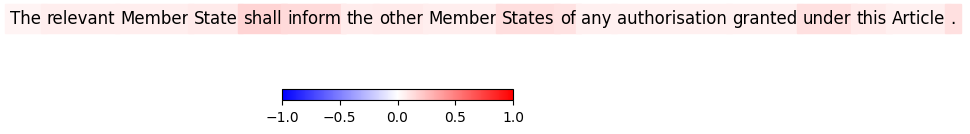

In [12]:
_ = visualization.highlight_text(explanation_relevance, model_runner.tokenizer.tokenize(statement))